# Alchemical Energies

In [7]:
import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm
import numpy as np
from matplotlib import pyplot as plt

In [12]:
# energy in diatomic
eH_H2 = (-1.029154884995695962e+00 + -1.029154960269883290e+00)/2
comps = ['CC', 'CN', 'CO', 'CF', 'NN', 'NO', 'NF', 'OO', 'OF', 'FF']
energies_diatomics = dict()
for c in comps:
    num_h1, num_h2 = uqm.hcount_smiles(c)
    en = np.loadtxt(f'/data/sahre/projects/atomic-energies/data/bonding_trends/alchemy/diatomics/{c}/atomic_energies.txt')[:,-1]
    if c[0] == c[1]: # homo diatomics
        energies_diatomics[f'{c[0]}_{c}'] = (en[0] + en[1])/2 # energy heavy atom A
        energies_diatomics[f'{c[0]}H_{c}'] = (en[2:].sum() + 2*eH_H2)/2#/(2*num_h1+2) # average energy of H's attached to A
        
    else:
        energies_diatomics[f'{c[0]}_{c}'] = en[0] # energy heavy atom A
        energies_diatomics[f'{c[1]}_{c}'] = en[1] # energy heavy atom B
        energies_diatomics[f'{c[0]}H_{c}'] = (en[2:2+num_h1].sum() + eH_H2)#/(num_h1+1) # average energy of H's attached to A
        energies_diatomics[f'{c[1]}H_{c}'] = (en[2+num_h1:].sum() + eH_H2)#/(num_h2+1) # average energy of H's attached to B 
# energy in fragment
energies_fragments = dict()
for c in ['C', 'N', 'O', 'F']:
    en = np.loadtxt(f'/data/sahre/projects/atomic-energies/data/bonding_trends/alchemy/sat_frags/{c}/atomic_energies_sat_frag.txt')[:,-1]
    energies_fragments[c] = en[0] # energy heavy atom A
    energies_fragments[c+'H'] = en[1:].sum()#en[1:].mean() # average energy of H's attached to A
# binding energy
energies_bind = dict()
for k in energies_diatomics.keys():
    frag = k.split('_')[0]
    energies_bind[k] = energies_diatomics[k] - energies_fragments[frag]

In [14]:
def key2(x):
    pattern_list = ['CC', 'CN', 'CO', 'CF', 'NN', 'NO', 'NF', 'OO', 'OF', 'FF']
    for i, p in enumerate(pattern_list):
        if p in x:
            return(i)
        
energies_bind_sorted = dict()

for el in ['C', 'N', 'O', 'F']:
    el_list = []
    el_list_H = []
    for k in energies_bind.keys():
        if k.split('_')[0] == el:
            el_list.append(k)
        elif k.split('_')[0] == el+'H':
            el_list_H.append(k)
    
    el_list = sorted(el_list, key=key2)
    el_list_H = sorted(el_list_H, key=key2)
    
    energies_bind_sorted[el] = []
    for k in el_list:
         energies_bind_sorted[el].append(energies_bind[k])
            
    energies_bind_sorted[el+'H'] = []
    for k in el_list_H:
         energies_bind_sorted[el+'H'].append(energies_bind[k]) 

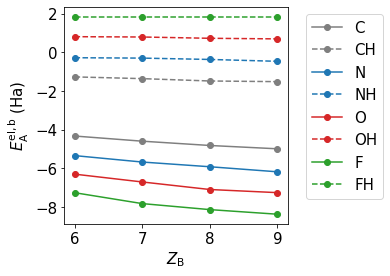

In [32]:
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = [4,4]

fig, ax = plt.subplots(1,1)
Z = [6,7,8,9]
el = ['C', 'N', 'O', 'F']
color = ['tab:gray', 'tab:blue', 'tab:red', 'tab:green']
for i in range(4):
    ax.plot(Z, energies_bind_sorted[el[i]], '-o', color = color[i], label = el[i])
    ax.plot(Z, energies_bind_sorted[el[i]+'H'], '--o', color = color[i], label = el[i]+'H')
    
ax.set_xlabel(r'$Z_{\rm{B}}$')
ax.set_ylabel(r'$E_{\rm{A}}^{\rm{el, b}}$ (Ha)')
ax.legend(bbox_to_anchor = [1.05, 1])
plt.savefig('/home/sahre/work/bonding_trends/figures/results/alchemical_binding_energies.svg', bbox_inches = 'tight')

In [ ]:




sorted(test_list, key = key2)

# Fit of binding energy

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm
import bt_tools as bt

In [ ]:
# load data

In [ ]:
data = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/all_energies.csv')
data_2 = data.loc[(data['Z1'] <= 9) & (data['Z2'] <= 9)].to_dict('list')
data_3 = data.loc[(data['Z1'] >= 14) & (data['Z2'] >= 14) & (data['Z1'] <= 17) & (data['Z2'] <= 17)].to_dict('list')
data_4 = data.loc[(data['Z1'] >= 32) & (data['Z2'] >= 32) & (data['Z1'] <= 35) & (data['Z2'] <= 35)].to_dict('list')
data_234 = data.loc[(data['Z1'] <= 9) & (data['Z2'] <= 9) | (data['Z1'] >= 14) & (data['Z2'] >= 14) & (data['Z1'] <= 17) & (data['Z2'] <= 17) | (data['Z1'] >= 32) & (data['Z2'] >= 32) & (data['Z1'] <= 35) & (data['Z2'] <= 35)].to_dict('list')

for d in [data_2, data_3, data_4, data_234]:
    d['unit'] = 630

In [ ]:
# do linear fits
b2 = bt.BDE_clean.fromdict(data_2)
b3 = bt.BDE_clean.fromdict(data_3)
b4 = bt.BDE_clean.fromdict(data_4)
for b in [b2, b3, b4]:
    b.linear_fit()
    print('MAE = ' + str((np.abs(b.bde-b.bde_fitted)).mean()))

In [ ]:
b3.linear_mae

In [ ]:
# non-linear fits

def non_linear_model(var, alpha, beta, b_prime, a, b):
    Z1, Z2 = var.T
    ebfe = (-beta*(Z1**(7/3)+Z2**(7/3))+alpha-b_prime*Z1*Z2)
    return(ebfe)

# do linear fits
b2_nl = bt.BDE_clean.fromdict(data_2)
b3_nl = bt.BDE_clean.fromdict(data_3)
b4_nl = bt.BDE_clean.fromdict(data_4)

for b in [b2_nl, b3_nl, b4_nl]:
    b.fit(non_linear_model)
    print('MAE = ' + str((np.abs(b.bde-b.bde_fitted)).mean()))

In [ ]:
comp = ['Ge', 'As', 'Se', 'Br']
labels = []
for i in range(4):
    for j in range(i, 4):
        labels.append(comp[i]+comp[j])

In [ ]:
bd = b4
bd_nl = b4_nl

plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['font.size'] = 18

fig, ax = plt.subplots(1,1)

ax.plot(bd.bde, '-o', label = 'PBE0') # refernce data

ax.plot(bd.bde_fitted, '--v', label = f'linear, MAE = {np.round(bd.linear_mae, 1)}') # linear fit

ax.plot(bd_nl.bde_fitted, '--x', label = f'non-linear, MAE = {np.round(bd_nl.mae, 1)}') # non-linear fit


# ax.set_xticks([])
# ax.set_xlabel('compound')
ax.set_ylabel('BDE (kcal/mol)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(frameon = False)

# plt.savefig('/home/sahre/work/bonding_trends/figures/results/r4_non_linear_fit.svg', bbox_inches = 'tight')

In [ ]:
emin = []
emax = []
for b in [b2, b3, b4]:
    emin.append(np.amin(b.bde) )
    emax.append(np.amax(b.bde))
emin = min(emin)
emax = max(emax)

ref_pts = [emin, emax]

In [ ]:


plt.rcParams['figure.figsize'] = [5,5]
plt.rcParams['font.size'] = 18
fig, ax = plt.subplots(1,1)

# row 2
bd = b2
bd_nl = b2_nl
ax.plot(bd.bde, bd.bde_fitted, 'o', label = 'row 2')

# row 3
bd = b3
bd_nl = b3_nl
ax.plot(bd.bde, bd.bde_fitted, 'v', label = 'row 3')

# row 4
bd = b4
bd_nl = b4_nl
ax.plot(bd.bde, bd.bde_fitted, 'x', label = 'row 4')

ax.plot(ref_pts, ref_pts, '--', color = 'tab:gray', linewidth = 1)

# ax.plot(bd.bde_fitted, '--v', label = f'linear, MAE = {np.round(bd.linear_mae, 1)}') # linear fit

# ax.plot(bd_nl.bde_fitted, '--x', label = f'non-linear, MAE = {np.round(bd_nl.mae, 1)}') # non-linear fit


ax.set_xlabel('BDE ref (kcal/mol)')
ax.set_ylabel('BDE fit (kcal/mol)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(frameon = False)
ax.axis('square')


# plt.savefig('/home/sahre/work/bonding_trends/figures/results/scatter_non_linear_fit.svg', bbox_inches = 'tight')

# Scatter Plot

# Molecular structures

In [ ]:
import ase.io as aio
from ase.visualize import view

In [ ]:

comps = ['CC', 'CN', 'CO', 'CF', 'NN', 'NO', 'NF', 'OO', 'OF', 'FF']

for c in comps:
    view(aio.read(f'/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/row_2/diatomics_single/{c}_opt.xyz'))

# Plot of slope m vs Z and intercept n vs Z

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ase.units import Bohr
from scipy.stats import linregress

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm
import bt_tools as bt

In [ ]:
def get_nbfe(charges):
    nbfe = []
    for i in range(len(charges)):
        for j in range(i, len(charges)):
            nbfe.append(charges[i]*charges[j])
            
    return(np.array(nbfe))

def linear_fit(b):
    charges = sorted(list(set(b.Z1)))
    m = b.linear_params[4:]

    out = linregress(charges, m)
    x = np.linspace(0, 36, 10)
    linf = out[0]*x+out[1]
    return(x, linf)



In [ ]:
data = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/all_energies.csv')
data_2 = data.loc[(data['Z1'] <= 9) & (data['Z2'] <= 9)].to_dict('list')
data_3 = data.loc[(data['Z1'] >= 14) & (data['Z2'] >= 14) & (data['Z1'] <= 17) & (data['Z2'] <= 17)].to_dict('list')
data_4 = data.loc[(data['Z1'] >= 32) & (data['Z2'] >= 32) & (data['Z1'] <= 35) & (data['Z2'] <= 35)].to_dict('list')
data_234 = data.loc[(data['Z1'] <= 9) & (data['Z2'] <= 9) | (data['Z1'] >= 14) & (data['Z2'] >= 14) & (data['Z1'] <= 17) & (data['Z2'] <= 17) | (data['Z1'] >= 32) & (data['Z2'] >= 32) & (data['Z1'] <= 35) & (data['Z2'] <= 35)].to_dict('list')

for d in [data_2, data_3, data_4, data_234]:
    d['unit'] = 630

for d, s in zip([data_2, data_3, data_4, data_234], [1.42, 2.12, 2.36, Bohr]):
    charges = sorted(list(set(d['Z1'])))
    d['nbfe'] = get_nbfe(charges)/(s/Bohr)
# do linear fits
b2 = bt.BDE_clean.fromdict(data_2)
b3 = bt.BDE_clean.fromdict(data_3)
b4 = bt.BDE_clean.fromdict(data_4)
for b in [b2, b3, b4]:
    b.linear_fit()

In [ ]:
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams['font.size'] = 18
fig, ax = plt.subplots(1,1)
plot_info = {'row':[b2, b3, b4], 'color':['tab:blue', 'tab:orange', 'tab:red'], 'row_number':['row 2', 'row 3', 'row 4']}
for i in range(3):

    charges = sorted(list(set(plot_info['row'][i].Z1)))
    ax.plot(charges, plot_info['row'][i].linear_params[4:], 'o', color = plot_info['color'][i], label = plot_info['row_number'][i])
    
    x, y = linear_fit(plot_info['row'][i])
    ax.plot(x, y, '--', color = plot_info['color'][i])

ax.plot([0, 36], [0,0], '--', color = 'tab:gray', linewidth = 1)
ax.set_xlim([0, 36])

ax.set_xlabel(r'$Z$')
ax.legend(frameon = False)

ax.set_yticks([0,-1000,-2000,-3000,-4000])
ax.set_yticklabels(['0','','','', ''])

ax.set_ylabel(r'$m(Z)$ (a.u.)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('/home/sahre/work/bonding_trends/figures/results/slopes.svg', bbox_inches = 'tight')

In [ ]:
def linear_fit_n(b):
    charges = np.array(sorted(list(set(b.Z1))))
    m = b.linear_params[:4]

    out = linregress(-(charges)**(7/3), m)
    x0 = np.amin(-(charges)**(7/3)) - 100*charges.mean()/30#+ np.amin(-(charges)**(7/3))*0.1
    x1 = np.amax(-(charges)**(7/3)) + 75*charges.mean()/30#- np.amax(-(charges)**(7/3))*0.1
    x = np.linspace(x0, x1, 10000)
    linf = out[0]*x+out[1]
    return(x, linf)

In [ ]:
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams['font.size'] = 18
fig, ax = plt.subplots(1,1)
plot_info = {'row':[b2, b3, b4], 'color':['tab:blue', 'tab:orange', 'tab:red'], 'row_number':['row 2', 'row 3', 'row 4']}


# ylim
y0 = np.amin(plot_info['row'][2].linear_params[:4]) - 10
y1 = np.amax(plot_info['row'][2].linear_params[:4]) + 10
ax.set_ylim([y0, y1])

# row 2
i = 0
charges = np.array(sorted(list(set(plot_info['row'][i].Z1))))
ax.plot(-(charges)**(7/3), plot_info['row'][i].linear_params[:4], 'o', color = plot_info['color'][i], label = plot_info['row_number'][i])

# linregress
out = linregress(-(charges)**(7/3), plot_info['row'][i].linear_params[:4])
x0 = (y0 - out[1])/out[0] #np.amin(-(charges)**(7/3)) - 20
x1 = (y1 - out[1])/out[0] #np.amax(-(charges)**(7/3)) + 20
x = np.linspace(x0, x1, 1000)
linf = out[0]*x+out[1]
ax.plot(x, linf, '--', color = plot_info['color'][i])

# row 3
i = 1
charges = np.array(sorted(list(set(plot_info['row'][i].Z1))))
ax.plot(-(charges)**(7/3), plot_info['row'][i].linear_params[:4], 'o', color = plot_info['color'][i], label = plot_info['row_number'][i])

# linregress
out = linregress(-(charges)**(7/3), plot_info['row'][i].linear_params[:4])
x0 = (y0 - out[1])/out[0] #np.amin(-(charges)**(7/3)) - 20
x1 = (y1 - out[1])/out[0] #np.amax(-(charges)**(7/3)) + 20
x = np.linspace(x0, x1, 1000)
linf = out[0]*x+out[1]
ax.plot(x, linf, '--', color = plot_info['color'][i])

# row 4
i = 2
charges = np.array(sorted(list(set(plot_info['row'][i].Z1))))
ax.plot(-(charges)**(7/3), plot_info['row'][i].linear_params[:4], 'o', color = plot_info['color'][i], label = plot_info['row_number'][i])

# linregress
out = linregress(-(charges)**(7/3), plot_info['row'][i].linear_params[:4])
x0 = (y0 - out[1])/out[0] #np.amin(-(charges)**(7/3)) - 20
x1 = (y1 - out[1])/out[0] #np.amax(-(charges)**(7/3)) + 20
x = np.linspace(x0, x1, 1000)
linf = out[0]*x+out[1]
ax.plot(x, linf, '--', color = plot_info['color'][i])

ax.set_xlabel(r'$-Z^{7/3}$')

ax.legend(frameon = False)

ax.set_ylabel(r'$n(Z)$ (a.u.)')

ax.set_yticks([0,-100, -200])
ax.set_yticklabels([])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('/home/sahre/work/bonding_trends/figures/results/intercepts.svg', bbox_inches = 'tight')

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
x = np.linspace(0, 20, 20)
plt.plot(x, -x+-x**(7/3))

In [ ]:
x = np.linspace(-10, 10, 10000000)
f1 = lambda x: (x**2-4)/(x**4-5*x**2+4)+(2*x**2-8)/(x**4-5*x**2+4)

plt.plot(x, f1(x))

In [ ]:
for xp in x:
    
    if np.abs(f1(xp) - 1) < 1e-5:
        print(xp)